# Laborarbeit Künstliche Intelligenz

## Thema :  Bayes Netze und Case Based Reasoning

### Namen des/r Studierenden: 

Niklas Werthmann

### Setup: Bibliotheken laden und Datensatz importieren

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination

plt.set_loglevel("warning") # Setze den Log-Level für Matplotlib auf "warning"

# Einlesen der CSV-Datei
file_path = './bikedata/sampled_data_004.csv'
data = pd.read_csv(file_path, sep=";", decimal=",")

### Datenbereinigung

#### Suche nach NaN Werten

In [4]:
print(data.isna().sum())   

Distance           0
Elapsed Time       0
Elevation High     0
Elevation Gain     0
Weekday            0
Bike Type         58
dtype: int64


Wir sehen, dass lediglich der Bike Type bei einigen Daten nicht bekannt ist. Da dies unsere Zielvariable ist, entfernen wir diese Datensätze.

In [5]:
data = data.dropna()

## Explorative Datenanalyse

In [6]:
data.head()

,Distance,Elapsed Time,Elevation High,Elevation Gain,Weekday,Bike Type
2,40.27,22875,2279.9,494.11,Saturday,mtb
3,3.23,1233,539.0,21.00,Wednesday,race bike
4,35.40,6199,371.0,157.00,Wednesday,trecking bike
5,65.38,10591,530.2,937.00,Saturday,race bike
6,52.38,7940,615.8,721.00,Saturday,race bike


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 189 entries, 2 to 246
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Distance        189 non-null    float64
 1   Elapsed Time    189 non-null    int64  
 2   Elevation High  189 non-null    float64
 3   Elevation Gain  189 non-null    float64
 4   Weekday         189 non-null    object 
 5   Bike Type       189 non-null    object 
dtypes: float64(3), int64(1), object(2)
memory usage: 10.3+ KB


In [8]:
data.describe()

,Distance,Elapsed Time,Elevation High,Elevation Gain
count,189.000000,189.000000,189.000000,189.000000
mean,40.362381,6947.867725,458.780423,412.484603
std,27.906235,5312.384989,322.351340,479.385288
min,3.230000,952.000000,-120.600000,13.800000
25%,28.300000,4697.000000,329.000000,146.000000
50%,35.250000,5666.000000,416.200000,279.000000
75%,41.890000,6810.000000,501.000000,517.000000
max,219.320000,45073.000000,2766.800000,4838.000000


Wir betrachten die Verteilung der Zielvariablen

In [9]:
print(data['Bike Type'].value_counts())

Bike Type
race bike        105
trecking bike     61
mtb               23
Name: count, dtype: int64


Und die deskriptive Statistik der Daten für jeden Bike Type

In [ ]:
grouped_data = data.groupby('Bike Type')
for bike_type, group in grouped_data:
    print(f"Descriptive statistics for {bike_type}:\n")
    print(group.describe())
    print("\n" + "-"*70 + "\n")

Descriptive statistics for mtb:

        Distance  Elapsed Time  Elevation High  Elevation Gain
count  23.000000     23.000000       23.000000       23.000000
mean   17.604348   4560.826087      384.743478      214.761739
std     9.200963   4421.963927      461.970185      121.670654
min     4.250000    952.000000     -120.600000       13.800000
25%    10.955000   2453.500000      170.400000      142.795000
50%    15.640000   3246.000000      359.000000      216.490000
75%    19.710000   4544.000000      413.300000      241.000000
max    40.270000  22875.000000     2279.900000      494.110000

----------------------------------------------------------------------

Descriptive statistics for race bike:

         Distance  Elapsed Time  Elevation High  Elevation Gain
count  105.000000    105.000000      105.000000      105.000000
mean    48.052571   7949.876190      542.256190      588.882000
std     32.171612   6251.371558      352.345925      567.584251
min      3.230000   1233.000000 

### Boxplots der numerischen Daten

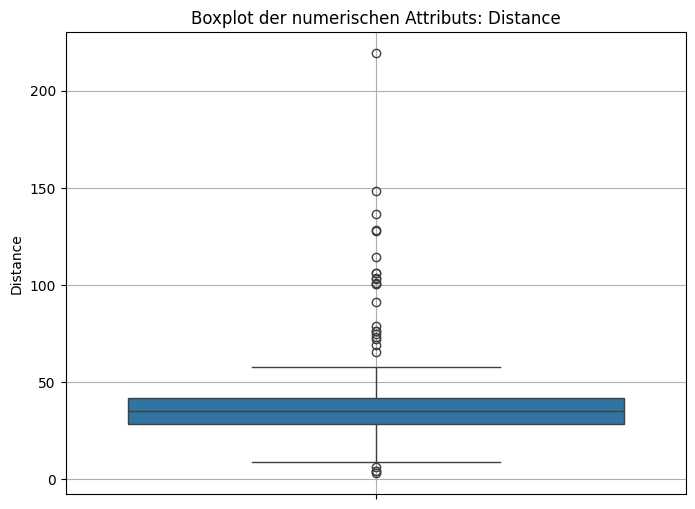

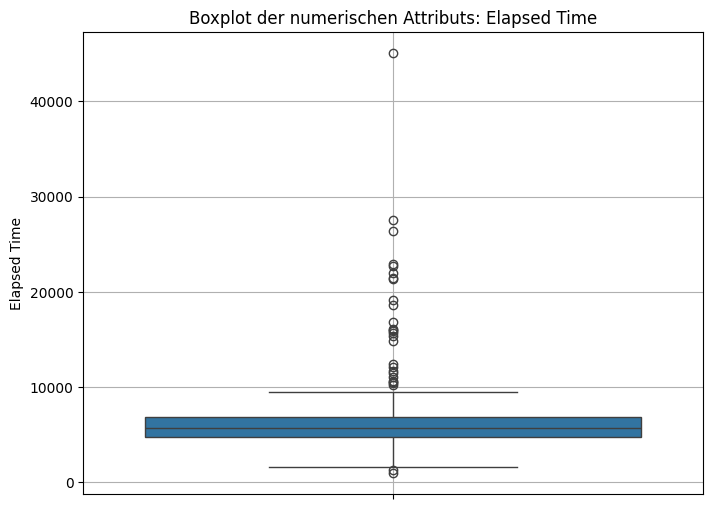

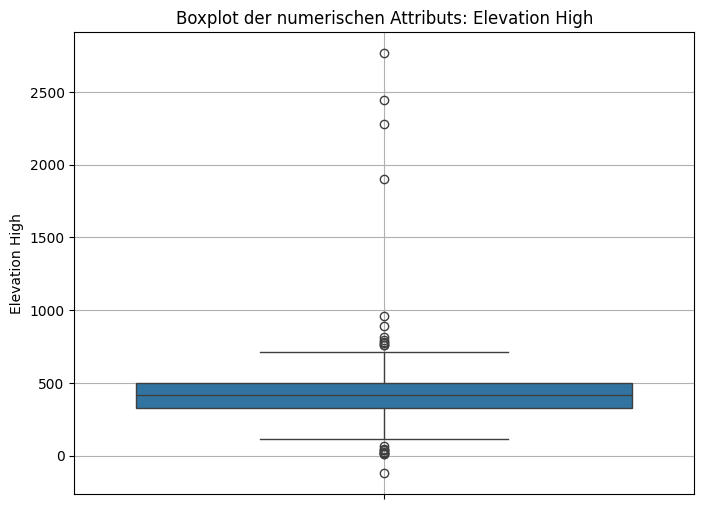

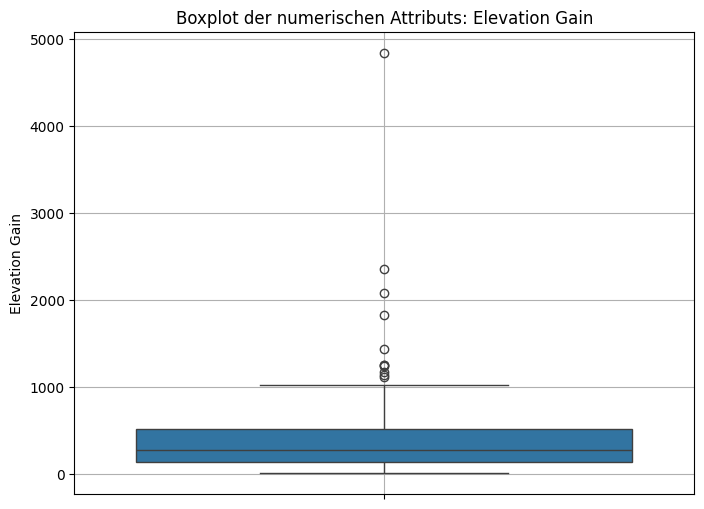

In [12]:
# Numerische Attribute - einzelne Boxplots
numeric_columns = data.select_dtypes(include='number').columns

for column in numeric_columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(y=data[column])
    plt.title(f'Boxplot der numerischen Attributs: {column}')
    plt.ylabel(column)
    plt.grid(True)
    plt.show()

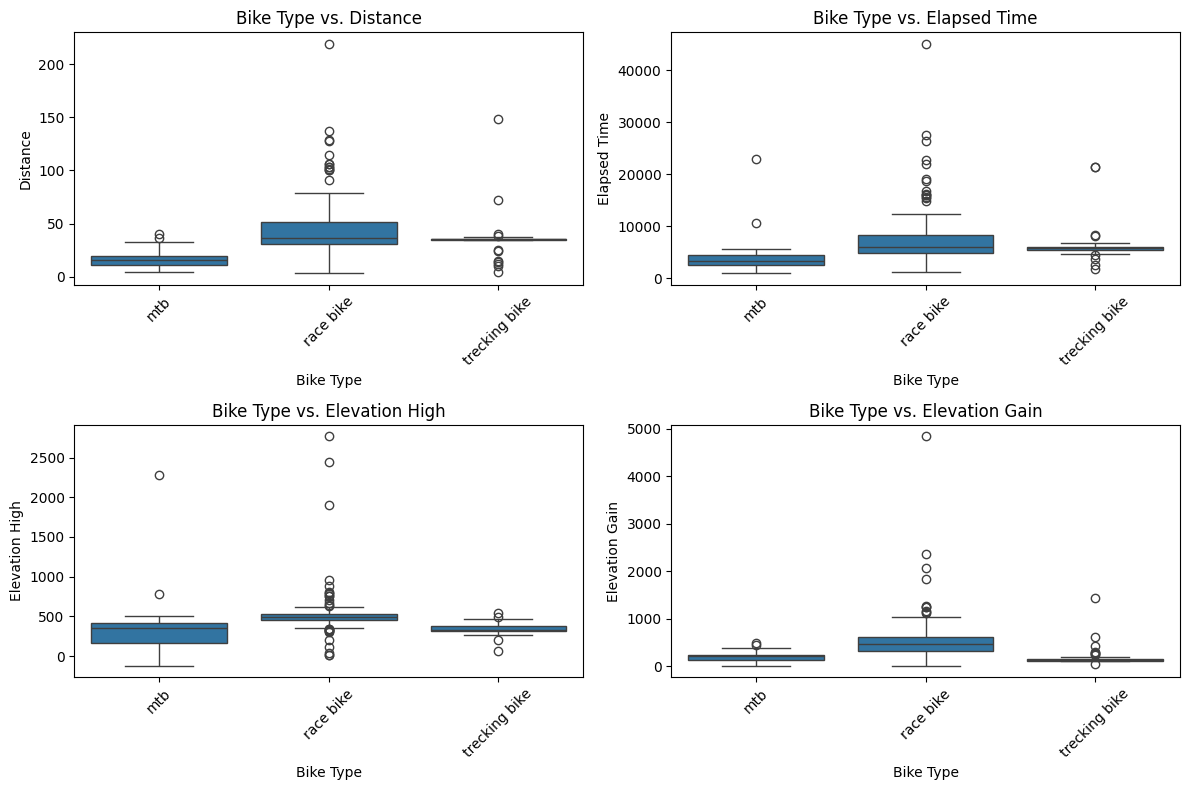

In [14]:
# Boxplots zur Analyse von Bike Type vs. Leistungswerte
plt.figure(figsize=(12, 8))
for i, col in enumerate(['Distance', 'Elapsed Time', 'Elevation High', 'Elevation Gain'], 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=data['Bike Type'], y=data[col])
    plt.title(f'Bike Type vs. {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

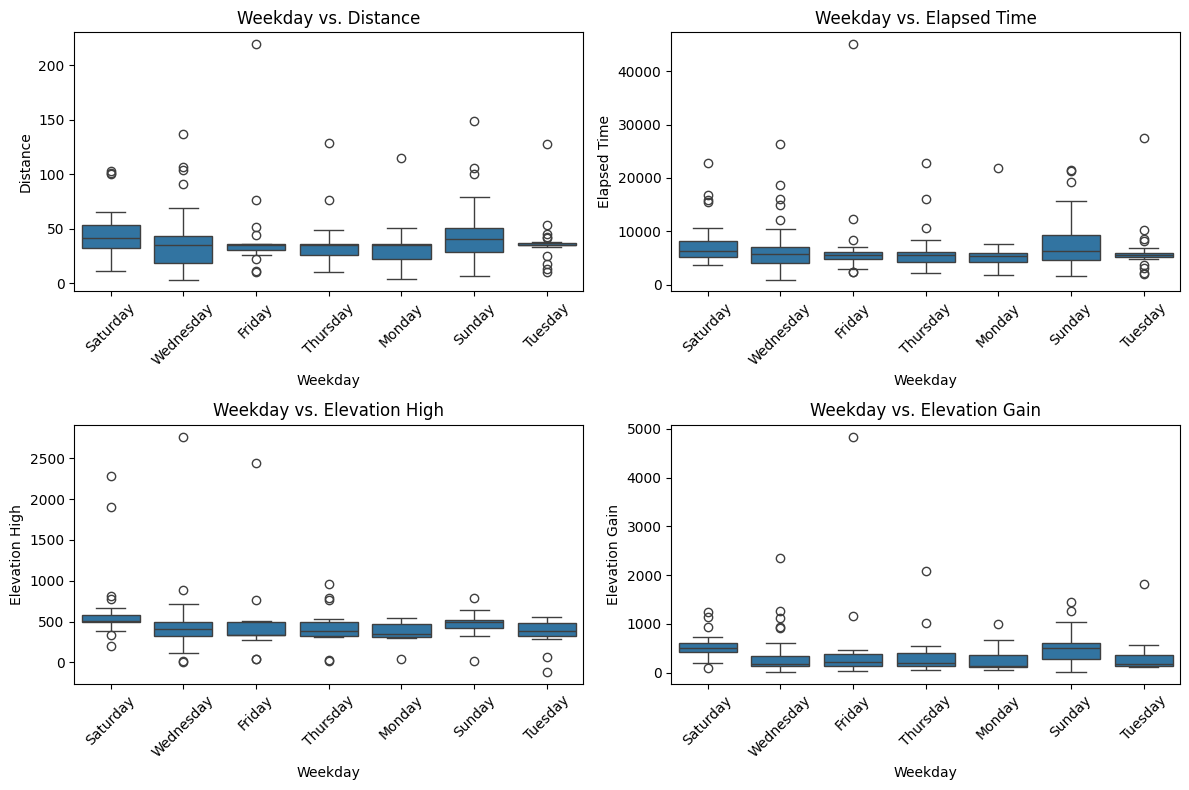

In [15]:
# Boxplots zur Analyse von Weekday vs. Leistungswerte
plt.figure(figsize=(12, 8))
for i, col in enumerate(['Distance', 'Elapsed Time', 'Elevation High', 'Elevation Gain'], 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=data['Weekday'], y=data[col])
    plt.title(f'Weekday vs. {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Häufigkeitsverteilungen der kategorialen Variablen

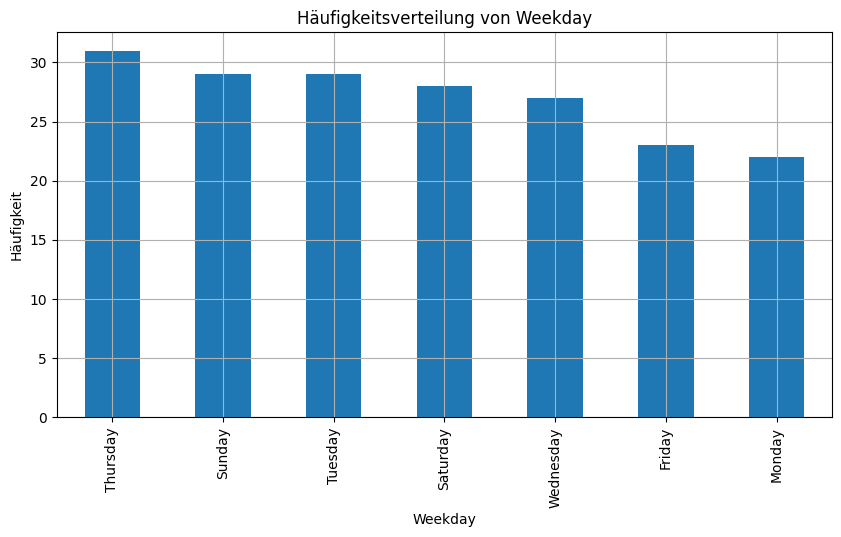

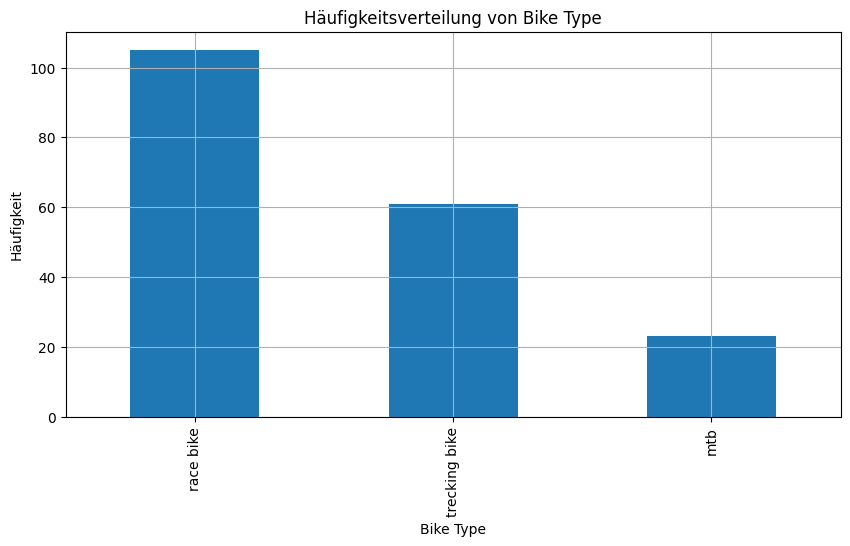

In [16]:
# Kategoriale Attribute - Häufigkeitsverteilungen
categorical_columns = data.select_dtypes(include='object').columns

for column in categorical_columns:
    plt.figure(figsize=(10, 5))
    data[column].value_counts().plot(kind='bar')
    plt.title(f'Häufigkeitsverteilung von {column}')
    plt.xlabel(column)
    plt.ylabel('Häufigkeit')
    plt.grid(True)
    plt.show()

### Scatterplot von Elevation Gain und Distance nach Bike Type

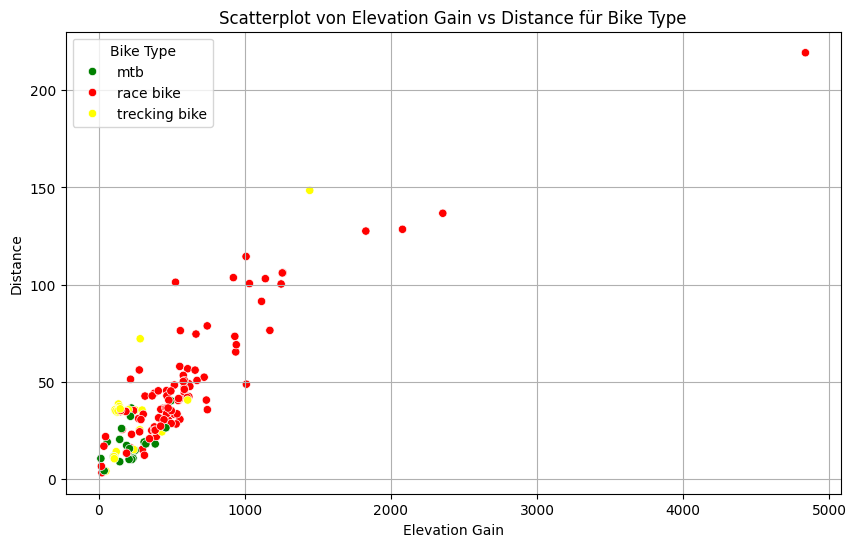

In [25]:
# Scatterplot für Elevation Gain und Distance basierend auf Bike Type

plt.figure(figsize=(10, 6))
colors = {'race bike': 'red', 'mtb': 'green', 'trecking bike': 'yellow'}
sns.scatterplot(data=data, x='Elevation Gain', y='Distance', hue='Bike Type', palette=colors)
plt.title('Scatterplot von Elevation Gain vs Distance für Bike Type')
plt.xlabel('Elevation Gain')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

### Verteilung der Bike Types über die Wochentage

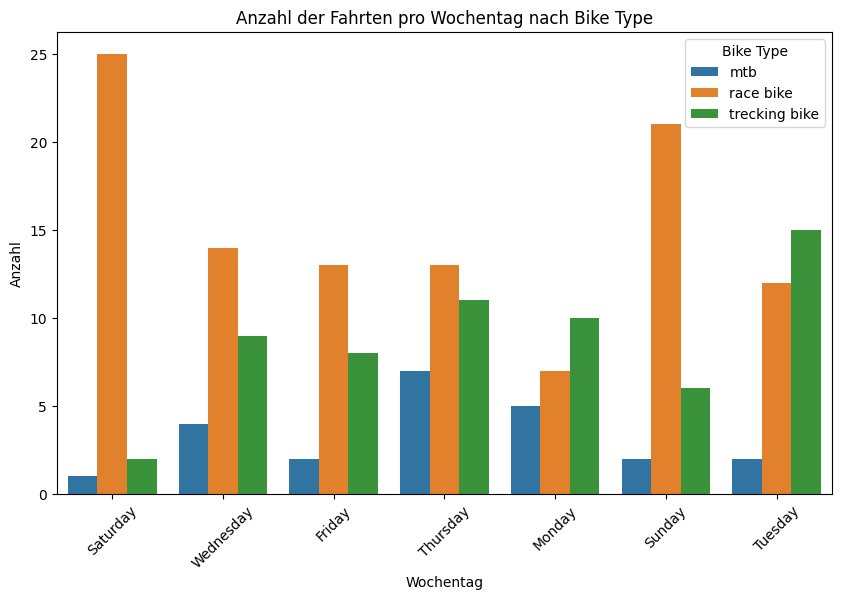

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Weekday', hue='Bike Type')
plt.title('Anzahl der Fahrten pro Wochentag nach Bike Type')
plt.xlabel('Wochentag')
plt.ylabel('Anzahl')
plt.xticks(rotation=45)
plt.legend(title='Bike Type')
plt.show()

### Korrelationsmatrix der numerischen Daten

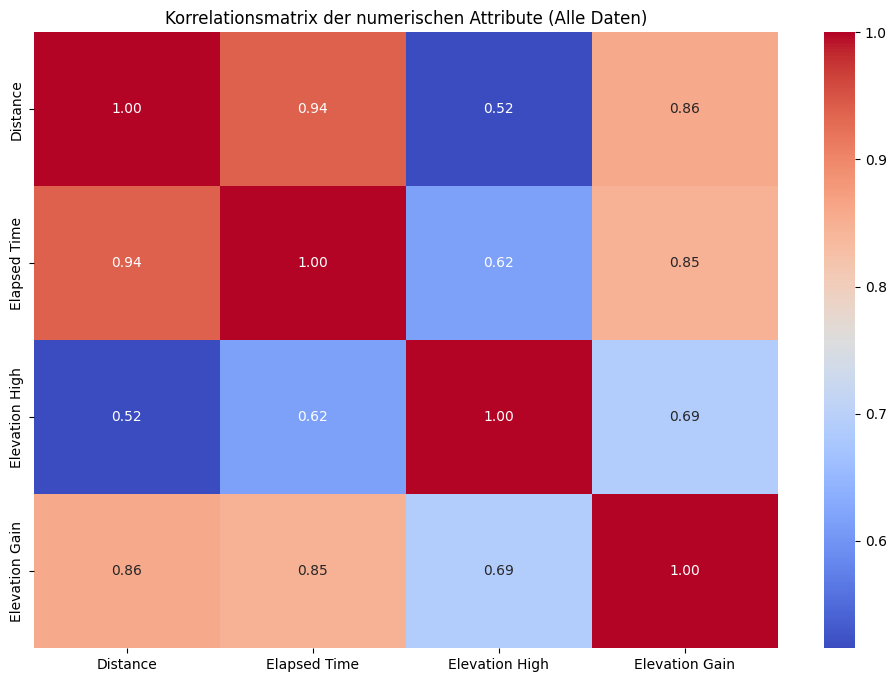

In [ ]:
correlation_matrix = data[['Distance', 'Elapsed Time', 'Elevation High', 'Elevation Gain']].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title('Korrelationsmatrix der numerischen Attribute (Alle Daten)')
plt.show()

## Aufgabenteil 1: Bayes Netze
Aufgabe: "Entwerfen Sie ein KI Modell auf Basis der Bayes Netze und setzen Sie dieses
als Jupyter Notebook um. Insbesondere wird eine geeignete Netzarchitektur und ein
Vorschlag für eine plausible Wahrscheinlichkeitsverteilung benötigt."

Wir beginnen mit der Definition des Bayes’schen Netzwerks und legen die kausalen Abhängigkeiten zwischen den Eingabemerkmalen und dem Zielmerkmal 'Bike Type' fest.

### 1. Modell anlegen

In [30]:
model = BayesianNetwork([
    ('Distance', 'Bike Type'),
    ('Elapsed Time', 'Bike Type'),
    ('Elevation High', 'Bike Type'),
    ('Elevation Gain', 'Bike Type'),
    ('Weekday', 'Bike Type'),
])

### Begründung zum Modell

Um die Struktur und Funktionsweise des Bayes’schen Netzwerks zunächst übersichtlich und nachvollziehbar zu halten, beschränken wir uns im ersten Schritt bewusst auf einen einzelnen Merkmalsknoten.

Diese Reduktion dient didaktischen Zwecken: Sie ermöglicht es, den Einfluss eines einzelnen Merkmals isoliert zu analysieren und die Inferenzmechanismen des Netzwerks klarer nachzuvollziehen.

### 2. CPTs anlegen

Das ist der Kern des Bayes'schen Netzes. Die CPTs können aus Daten gewonnen werden, sofern viele da sind. Ansonsten ist zusätzlich Hintergrundwissen und Schätzung zu verwenden.

#### 2.1 Elapsed Time

In [31]:
# Basierend auf der deskriptiven Statistik:
# count    189
# mean     ~6948
# std      ~5312
# min      952
# 25%      4697
# 50%      5666
# 75%      6810
# max      45073

# Wir nehmen folgende Schwellen für die Diskretisierung:
# - "low"    = Elapsed Time ≤ 5666  (unterhalb des Medians)
# - "medium" = 5666 < Elapsed Time ≤ 6810 (zwischen Median und 75%)
# - "high"   = Elapsed Time > 6810  (oberhalb des 75%-Perzentils)

# Diese Einteilung ergibt realistische, datenbasierte Gruppen:
# - "low": kurze, eventuell alltägliche Fahrten
# - "medium": mittellange Touren
# - "high": lange oder außergewöhnliche Fahrten

# Berechnung der Wahrscheinlichkeitsverteilung für die diskretisierten Werte

In [32]:
print(pd.cut(data['Elapsed Time'],bins=[0, 5666, 6810, np.inf], labels=['low', 'medium', 'high']).value_counts(normalize=True).sort_index())

Elapsed Time
low       0.502646
medium    0.248677
high      0.248677
Name: proportion, dtype: float64


In [33]:
# Wir erhalten:
# low      ~0.5026
# medium   ~0.2487
# high     ~0.2487

# Dann ist die CPT wie folgt:
cpd_elapsed_time = TabularCPD(
    variable='Elapsed Time',
    variable_card=3,
    values=[
        [0.5026],    # P(low)
        [0.2487],   # P(medium)
        [0.2487]    # P(high)
    ],
    state_names={'Elapsed Time': ['low', 'medium', 'high']})

#### 2.2 Distance

In [34]:
# Basierend auf der deskriptiven Statistik:
# count    189
# mean     ~40.36
# std      ~27.91
# min      3.23
# 25%      28.30
# 50%      35.25
# 75%      41.89
# max      219.32

# Wir nehmen folgende Schwellen für die Diskretisierung:
# - "short" = Distance ≤ 35.25 
# - "medium" = 35.25 < Distance ≤ 41.89
# - "long"  = Distance > 41.89 
#
# Begründung:
# Der Median (35.25) liefert einen robusten Schätzer für den Mittelpunkt der Verteilung.
# Damit wird tendenziell die Hälfte der beobachteten Strecken als "short" und die andere Hälfte als "long" klassifiziert.
# Dies ist sinnvoll, da wir davon ausgehen, dass längere Distanzen eine besondere Charakteristik besitzen.

# Berechnung der Wahrscheinlichkeitsverteilung für die diskretisierten Werte

In [35]:
print(pd.cut(data['Distance'], bins=[0, 35.25 , 41.89, np.inf], labels=['short', 'medium', 'long']).value_counts(normalize=True).sort_index())

Distance
short     0.502646
medium    0.248677
long      0.248677
Name: proportion, dtype: float64


In [36]:
# Wir erhalten:
# short      ~0.5026
# medium   ~0.2487
# long     ~0.2487

# Dann ist die CPT wie folgt:
cpd_distance = TabularCPD(
    variable='Distance',
    variable_card=3,
    values=[
        [0.5026],    # P(short)
        [0.2487],   # P(medium)
        [0.2487]    # P(long)
    ],
    state_names={'Distance': ['short', 'medium', 'long']}
)

#### 2.3 Elevation High

In [37]:
# Basierend auf der deskriptiven Statistik:
# count    189
# mean     ~458.78
# std      ~322.35
# min      -120.6
# 25%      329.0
# 50%      416.2
# 75%      501.0
# max      2766.8

# Wir wählen den Median als Trennwert, da er robust gegenüber Ausreißern ist.
# Diskretisierungsregel:
# - "low"  = Elevation High ≤ 416.2 
# - "high" = Elevation High > 416.2 
#
# Hier wählen wir nur zwei Kategorien ("low" und "high"), da die Daten grundsätzlich wenig streuen,
# aber einige extreme Ausreißer vorhanden sind. 

# Berechnung der Wahrscheinlichkeitsverteilung für die diskretisierten Werte

In [38]:
print(pd.cut(data['Elevation High'], bins=[-np.inf, 416.2, np.inf], labels=['low', 'high']).value_counts(normalize=True).sort_index())

Elevation High
low     0.502646
high    0.497354
Name: proportion, dtype: float64


In [39]:
# Wir erhalten:
# low     ~0.5026
# high    ~0.4974

# Dann ist die CPT wie folgt:
cpd_elevation_high = TabularCPD(
    variable='Elevation High',
    variable_card=2,
    values=[
        [0.5026],  # P(low)
        [0.4974]   # P(high)
    ],
    state_names={'Elevation High': ['low', 'high']}
)

#### 2.4 Elevantion Gain

In [40]:
# Basierend auf der deskriptiven Statistik:
# count    189
# mean     ~412.48
# std      ~479.39
# min      13.80
# 25%      146.00
# 50%      279.00
# 75%      517.00
# max      4838.00

# Diskretisierungsregel:
# Wir unterteilen Elevation Gain in drei Kategorien:
# - "low":  Elevation Gain ≤ 279 
# - "medium": 279 < Elevation Gain ≤ 517 
# - "high":   Elevation Gain > 517 
#
# Begründung:
# tbd.

# Berechnung der Wahrscheinlichkeitsverteilung für die diskretisierten Werte

In [41]:
print(pd.cut(data['Elevation Gain'], bins=[0, 279, 517, np.inf], labels=['low', 'medium', 'high']).value_counts(normalize=True).sort_index())

Elevation Gain
low       0.502646
medium    0.248677
high      0.248677
Name: proportion, dtype: float64


In [42]:
# Wir erhalten:
# low     ~0.5026
# medium  ~0.2487
# high    ~0.2487

# Dann ist die CPT wie folgt:

cpd_elevation_gain = TabularCPD(
    variable='Elevation Gain',
    variable_card=3,
    values=[
        [0.5026],   # P(low)
        [0.2487],   # P(medium)
        [0.2487]    # P(high)
    ],
    state_names={'Elevation Gain': ['low', 'medium', 'high']}
)

#### 2.5 Weekday

In [43]:
# Diskretisierungsregel:
# Wir unterteilen Weekday in zwei Kategorien:
# - "weekday":  Monday to Friday
# - "weekend":  Saturday & Sunday
#
# Begründung:
# Die Analyse zeigt, dass Race Bikes zwar unter der Woche bereits am häufigsten genutzt werden, 
# jedoch ist ihr Anteil am Wochenende im Vergleich zu den anderen Bike Types noch ausgeprägter.

In [44]:
print(data['Weekday'].apply(lambda x: 'weekend' if x in ['Saturday', 'Sunday'] else 'weekday').value_counts(normalize=True).sort_index())

Weekday
weekday    0.698413
weekend    0.301587
Name: proportion, dtype: float64


In [45]:
# Wir erhalten:
# weekday    ~0.6984
# weekend    ~0.3016

# Dann ist die CPT wie folgt:
cpd_weekday = TabularCPD(
    variable='Weekday',
    variable_card=2,
    values=[
        [0.6984],   # P(weekday)
        [0.3016]    # P(weekend)
    ],
    state_names={'Weekday': ['weekday', 'weekend']})

#### 2.6  Biketype

In [46]:
# Wir erstellen eine neue DataFrame-Kopie mit allen diskretisierten Merkmalen
df_cpt = data.copy()

# Diskretisierung (wie oben schon verwendet)
df_cpt['Elapsed Time'] = pd.cut(df_cpt['Elapsed Time'], bins=[0, 5666, 6810, np.inf], labels=['low', 'medium', 'high'])
df_cpt['Distance'] = pd.cut(df_cpt['Distance'], bins=[0, 35.25, 41.89, np.inf], labels=['short', 'medium', 'long'])
df_cpt['Elevation High'] = pd.cut(df_cpt['Elevation High'], bins=[-np.inf, 416.2, np.inf], labels=['low', 'high'])
df_cpt['Elevation Gain'] = pd.cut(df_cpt['Elevation Gain'], bins=[0, 279, 517, np.inf], labels=['low', 'medium', 'high'])
df_cpt['Weekday'] = df_cpt['Weekday'].apply(lambda x: 'weekend' if x in ['Saturday', 'Sunday'] else 'weekday')

# Jetzt gruppieren wir nach allen Eltern und zählen die Bike Types
grouped = df_cpt.groupby(['Elapsed Time', 'Distance', 'Elevation High', 'Elevation Gain', 'Weekday', 'Bike Type'], observed=False).size()
grouped = grouped.unstack(fill_value=0)

# In relative Häufigkeiten umwandeln (Wahrscheinlichkeiten)
cpt_bike_type = grouped.div(grouped.sum(axis=1), axis=0)

In [47]:
# Elternvariablen in folgender Reihenfolge:
# ['Distance', 'Elapsed Time', 'Elevation High', 'Elevation Gain', 'Weekday']

# Anzahl der Zustände je Variable
# Elapsed Time: 3 (low, medium, high)
# Distance: 3  (short, medium, long)
# Elevation High: 2 (low, high)
# Elevation Gain: 3 (low, medium, high)
# Weekday: 2 (weekday, weekend)

# Bike Type (Zielvariable): 3 Klassen, z.B. ['mtb', 'race bike', 'trecking bike']

In [48]:
# Also:
evidence = ['Elapsed Time', 'Distance', 'Elevation High', 'Elevation Gain', 'Weekday']
evidence_card = [3, 3, 2, 3, 2]

In [49]:
# Sicherstellen, dass alle Kombinationen vorhanden sind
# Fehlende Kombinationen mit 0 oder gleichverteilten Wahrscheinlichkeiten auffüllen
all_states = pd.MultiIndex.from_product([
    ['low', 'medium', 'high'],
    ['short', 'medium', 'long'],
    ['low', 'high'],
    ['low', 'medium', 'high'],
    ['weekday', 'weekend']
], names=['Elapsed Time', 'Distance','Elevation High', 'Elevation Gain', 'Weekday'])

cpt_complete = cpt_bike_type.reindex(all_states).fillna(1/3)  # gleichverteilt für leere Zellen

# Klassen von Bike Type
bike_type_states = ['mtb', 'race bike', 'trecking bike']

# Extrahiere als Liste von Listen (je eine Liste pro Bike Type, transponiert für pgmpy)
cpt_values = [
    cpt_complete[bike_type].values.tolist() for bike_type in bike_type_states
]

In [50]:
cpd_bike_type = TabularCPD(
    variable='Bike Type',
    variable_card=3,
    values=cpt_values,
    evidence=['Elapsed Time', 'Distance', 'Elevation High', 'Elevation Gain', 'Weekday'],
    evidence_card=[3, 3, 2, 3, 2],
    state_names={
        'Bike Type': bike_type_states,
        'Elapsed Time': ['low', 'medium', 'high'],
        'Distance': ['short', 'medium', 'long'],
        'Elevation High': ['low', 'high'],
        'Elevation Gain': ['low', 'medium', 'high'],
        'Weekday': ['weekday', 'weekend']
    }
)

#### 2.6 CPTs zum Modell hinzufügen

In [51]:
# Alle bereits definierten CPDs ins Modell einfügen
model.add_cpds(
    cpd_distance,
    cpd_elapsed_time,
    cpd_elevation_high,
    cpd_elevation_gain,
    cpd_weekday,
    cpd_bike_type 
)

#### 2.8 Modell überprüfen

In [52]:
# Prüfen, ob das Modell korrekt ist
assert model.check_model(), "Modell ist nicht konsistent – prüfe CPTs!"
print("Bayes-Netzwerk erfolgreich aufgebaut und validiert.")

Bayes-Netzwerk erfolgreich aufgebaut und validiert.


### 3. Inferenz

Nutzen Sie nun die Inferenz der Bayes Netze um die Klassifikation durchzuführen.


In [53]:
# Inferenz-Objekt erstellen
infer = VariableElimination(model)

# Beispielhafte Inferenz: Wie wahrscheinlich ist es, dass ein Bike ein 'race bike' ist,
# wenn folgende Merkmalsausprägungen beobachtet werden?
evidence_sample = {
    'Distance': 'long',
    'Elapsed Time': 'high',
    'Elevation High': 'high',
    'Elevation Gain': 'high',
    'Weekday': 'weekend'
}

# Inferenz durchführen
print(infer.query(variables=['Bike Type'], evidence=evidence_sample))


+--------------------------+------------------+
| Bike Type                |   phi(Bike Type) |
+==========================+==================+
| Bike Type(mtb)           |           0.0000 |
+--------------------------+------------------+
| Bike Type(race bike)     |           0.9412 |
+--------------------------+------------------+
| Bike Type(trecking bike) |           0.0588 |
+--------------------------+------------------+


### 4. Test und Bewertung 

Testen Sie die Funktionsweise Ihres Netzes und diskutieren Sie die Ergebnisse.

In [54]:
# Vorbereitung: Diskretisierung wie im Modell
test_data = df_cpt.copy()

# Liste zur Speicherung der Vorhersagen
predictions = []

for i, row in test_data.iterrows():
    evidence = {
        'Distance': row['Distance'],
        'Elapsed Time': row['Elapsed Time'],
        'Elevation High': row['Elevation High'],
        'Elevation Gain': row['Elevation Gain'],
        'Weekday': row['Weekday']
    }
    # Inferenz durchführen
    result = infer.query(variables=['Bike Type'], evidence=evidence)
    
    # Vorhersage: die Klasse mit der höchsten Wahrscheinlichkeit
    predicted_class = result.values.argmax()
    predicted_label = result.state_names['Bike Type'][predicted_class]
    predictions.append(predicted_label)

# Tatsächliche Labels
true_labels = test_data['Bike Type'].tolist()

# Bewertung
print("Accuracy:", accuracy_score(true_labels, predictions))
print("\nClassification Report:")
print(classification_report(true_labels, predictions))


Accuracy: 0.8095238095238095

Classification Report:
               precision    recall  f1-score   support

          mtb       0.75      0.13      0.22        23
    race bike       0.94      0.88      0.91       105
trecking bike       0.67      0.95      0.78        61

     accuracy                           0.81       189
    macro avg       0.79      0.65      0.64       189
 weighted avg       0.83      0.81      0.78       189



### Diskussion der Ergebnisse 

Die Vorhersagen des Bayes-Netzes wurden mit den tatsächlichen Labels verglichen, wobei die folgenden Metriken ermittelt wurden:

Accuracy: 0.81

Precision (Macro Average): 0.79

Recall (Macro Average): 0.65

F1-Score (Macro Average): 0.64

Interpretation:
Das Modell erreicht eine insgesamt gute Genauigkeit (81 %), was bedeutet, dass die Mehrheit der Vorhersagen korrekt ist.

Race Bikes werden mit sehr hoher Präzision (0.94) und Recall (0.88) erkannt – das Modell ist hier besonders zuverlässig.

Trecking Bikes werden ebenfalls recht gut erkannt (Recall: 0.95), auch wenn die Präzision etwas geringer ausfällt (0.67), was auf einige Verwechslungen mit anderen Klassen hinweist.

MTBs bereiten dem Modell dagegen Probleme: Der Recall ist mit 0.13 sehr niedrig, d.h. die meisten MTBs werden fälschlich als andere Typen klassifiziert. Dies könnte durch eine geringe Anzahl von Trainingsbeispielen oder durch eine starke Ähnlichkeit zu anderen Typen bedingt sein.

Fazit:
Das Bayes-Netz bietet eine solide Grundlage zur Klassifikation von Fahrradtypen, insbesondere für Race Bikes. Für eine bessere Differenzierung der MTB-Klasse wäre ggf. eine andere Merkmalsauswahl, feinere Diskretisierung oder eine alternative Modellstruktur sinnvoll.

## Aufgabenteil 2: Case Based Reasoning

Entwerfen Sie ein KI Modell auf Basis von Case Based Reasoning und setzen
Sie dieses als Jupyter Notebook um. Wählen Sie geeignete Vorgehensweisen um die Fallbasis
aufzubauen (CBL) und geeignete Ähnlichkeitsmaße.

In [55]:
discretized_data = data[['Elapsed Time', 'Distance', 'Elevation High', 'Elevation Gain', 'Weekday', 'Bike Type']].copy()

# Diskretisierung der numerischen Spalten wie in Aufgabe 1
discretized_data['Elapsed Time'] = pd.cut(discretized_data['Elapsed Time'], bins=[0, 5666, 6810, np.inf], labels=['low', 'medium', 'high'])
discretized_data['Distance'] = pd.cut(discretized_data['Distance'], bins=[0, 35.25, 41.89, np.inf], labels=['short', 'medium', 'long'])
discretized_data['Elevation High'] = pd.cut(discretized_data['Elevation High'], bins=[-np.inf, 416.2, np.inf], labels=['low', 'high'])
discretized_data['Elevation Gain'] = pd.cut(discretized_data['Elevation Gain'], bins=[0, 279, 517, np.inf], labels=['low', 'medium', 'high'])
discretized_data['Weekday'] = discretized_data['Weekday'].apply(lambda x: 'weekend' if x in ['Saturday', 'Sunday'] else 'weekday')

### 1. Ähnlichkeitsmaß definieren

Entwerfen Sie ein zur Aufgabenstellung passendes und geeignetes Ähnlichkeitsmaß.

Im CBR-Ansatz geht man davon aus, dass ähnliche Fälle (z. B. Fahrten) zu ähnlichen Ergebnissen (hier: Klassifikation des „Bike Type“) führen. Da in unserem Fall alle relevanten Merkmale (wie „Elapsed Time“, „Distance“, „Elevation High“, „Elevation Gain“ und „Weekday“) bereits diskretisiert vorliegen, verwenden wir einen gewichteten Matching-Koeffizienten:

Für jedes Merkmal prüfen wir, ob beide Fälle identisch sind.

Wir vergeben pro Übereinstimmung einen gewichteten Punktanteil und summieren alle Bewertungen.

Somit erhalten wir am Ende einen Ähnlichkeitswert zwischen 0 und 1.

Im folgenden Beispiel kommen unterschiedliche Gewichte zum Einsatz. Diese können – je nach Fachwissen und empirischer Validierung – angepasst werden.

In [56]:
def aehnlichkeit(fall1, fall2):
    """
    Berechnet die Ähnlichkeit zwischen zwei Fällen anhand diskreter Merkmalsausprägungen.
    Es wird ein gewichteter Matching-Koeffizient verwendet.

    Args:
        person1 (dict): Ein Fall als Dictionary mit diskretisierten Merkmalen.
        person2 (dict): Ein Fall als Dictionary mit diskretisierten Merkmalen.

    Returns:
        float: Ein Wert zwischen 0 und 1, der die Ähnlichkeit angibt.
    """

    # Merkmale, die für den Vergleich berücksichtigt werden sowie die Gewichte für die einzelnen Merkmale
    merkmale_und_gewichte = {
        'Elapsed Time': 1,
        'Distance': 0.25,
        'Elevation High': 0.25,
        'Elevation Gain': 0.25,
        'Weekday': 0.1
    }

    score = 0.0
    gesamtgewicht = sum(merkmale_und_gewichte.values())
    
    for merkmal, gewicht in merkmale_und_gewichte.items():
        # Falls beide Fälle im jeweiligen Merkmal übereinstimmen, wird das Gewicht addiert.
        if fall1.get(merkmal) == fall2.get(merkmal):
            score += gewicht

    # Normierung auf den Bereich [0,1]
    return score / gesamtgewicht

Test am Beispiel

In [57]:
# Wir nutzen die zuvor diskretisierten Daten
fall1 = discretized_data.iloc[0].to_dict()
fall2 = discretized_data.iloc[1].to_dict()

print(fall1)
print(fall2)

print("Ähnlichkeit: ", aehnlichkeit(fall1, fall2))

{'Elapsed Time': 'high', 'Distance': 'medium', 'Elevation High': 'high', 'Elevation Gain': 'medium', 'Weekday': 'weekend', 'Bike Type': 'mtb'}
{'Elapsed Time': 'low', 'Distance': 'short', 'Elevation High': 'high', 'Elevation Gain': 'low', 'Weekday': 'weekday', 'Bike Type': 'race bike'}
Ähnlichkeit:  0.13513513513513511


### Begründung zur Wahl des Ähnlichkeitsmaßes

Diskrete Merkmalsausprägungen: Da alle relevanten Merkmale diskretisiert wurden (analog zu Teil 1), bietet sich ein Matching-Koeffizient an, der per Feature prüft, ob die Ausprägungen übereinstimmen.

Gewichtete Kombination: Unterschiedliche Merkmale können unterschiedliche Relevanz besitzen. Mit gewichteter Aggregation lässt sich etwa abbilden, dass die Fahrzeit oder die Distanz stärker ins Gewicht fallen als der Wochentag.

Einfachheit und Interpretierbarkeit: Der Ansatz ist nachvollziehbar und ermöglicht eine einfache Anpassung der Gewichte je nach empirischer Evaluation.

### 2. CBR Zyklus umsetzen

Zunächst wird RETRIEVE benötigt. Dann sollte geprüft werden ob das Ergebnis bereits ausreicht. Wenn nicht, sollte geprüft werden, ob man die Daten in die Fallbasis aufnimmt. Die Fallbasis ist klein zu halten.

Im Rahmen des CBR-Zyklus führen wir zunächst den RETRIEVE-Schritt durch, indem wir den Fall in der Fallbasis finden, der die größte Ähnlichkeit zum zu klassifizierenden Fall aufweist. Anschließend wird geprüft, ob die Ähnlichkeit einen vordefinierten Schwellenwert überschreitet. Falls ja, wird der Fall als ausreichend ähnlich angesehen und dessen Klassifikation übernommen. Andernfalls kann man den neuen Fall in die Fallbasis aufnehmen (RETAIN), um zukünftig ähnliche Fälle besser zu klassifizieren.

Funktion zur Bestimmung des ähnlichsten Falls
Die folgende Funktion finde_aehnlichsten_fall iteriert über die Fallbasis (hier ein DataFrame) und gibt den Index, den Ähnlichkeitswert sowie den zugehörigen Fall zurück.

Vergleichsfunktion zur Bestimmung des ähnlichsten Falls

In [58]:
def finde_aehnlichsten_fall(df, person_zu_vergleichen):
    """
    Findet den Fall im DataFrame, der den höchsten Ähnlichkeitswert zur gegebenen Person hat.

    Args:
        df (pd.DataFrame): DataFrame mit den diskretisierten Fahrtdaten und zugehörigen Labels.
        person_zu_vergleichen (dict): Merkmalswerte des neuen Falls.

    Returns:
        tuple: (index, höchster Ähnlichkeitswert, Fall als Series)
    """
    max_aehnlichkeit = -1
    index_aehnlichster_fall = -1
    aehnlichster_datensatz = None

    for i, row in df.iterrows():
        fall = row.to_dict()
        # Berechnung der Ähnlichkeit basierend auf den definierten Merkmalen
        a = aehnlichkeit(person_zu_vergleichen, fall)
        if a > max_aehnlichkeit:
            max_aehnlichkeit = a
            index_aehnlichster_fall = i
            aehnlichster_datensatz = row

    return index_aehnlichster_fall, max_aehnlichkeit, aehnlichster_datensatz

In [59]:
# Test der Funktion mit fiktiven Daten:

fall_fiktiv = {'Elapsed Time': 'high', 'Distance': 'long', 'Elevation High': 'high',
            'Elevation Gain': 'medium', 'Weekday': 'weekday'}

idx, sim, retrieved = finde_aehnlichsten_fall(discretized_data, fall_fiktiv)
print("Index:", idx)
print("Ähnlichkeit:", sim)
print("Ähnlichster Datensatz:\n", retrieved)

bike_type = retrieved['Bike Type']
print(f"Daher sollte das Fahrrad vom Type {bike_type} sein.")

Index: 42
Ähnlichkeit: 1.0
Ähnlichster Datensatz:
 Elapsed Time           high
Distance               long
Elevation High         high
Elevation Gain       medium
Weekday             weekday
Bike Type         race bike
Name: 42, dtype: object
Daher sollte das Fahrrad vom Type race bike sein.


Erstellen einer Fallbasis (CBL Zyklus)

In [60]:
cases = pd.DataFrame(columns=['Elapsed Time', 'Distance', 'Elevation High', 'Elevation Gain', 'Weekday', 'Bike Type'])

Die Fallbasis ist zunächst leer. Diese wird nun nach dem CBL Algorithmus (Instance Based Learning) gefüllt. Vorgehen: Ein Fall wird aufgenommen, wenn er bisher nicht richtig klassifiziert wird.

In [61]:
# Füge den ersten Eintrag von data zu cases hinzu (initialisieren)
initial = discretized_data.iloc[0]
cases = pd.concat([cases, initial.to_frame().T], ignore_index=True)

In [62]:
for index, row in discretized_data.iterrows():
    # Finde den ähnlichsten Fall in "cases"
    i, m, case = finde_aehnlichsten_fall(cases, row)

    # Vergleiche den Versicherungstarif
    if case['Bike Type'] != row['Bike Type']:
        # Füge den Datensatz zu "cases" hinzu
        cases = pd.concat([cases, row.to_frame().T], ignore_index=True)

In [63]:
print(f"Der Datensatz der Größe {len(discretized_data)} wurde in {len(cases)} Fällen gespeichert.")

Der Datensatz der Größe 189 wurde in 66 Fällen gespeichert.


In [66]:
def treffer(discretized_data, cases):
    """
    Überprüft, wie oft finde_aehnlichsten_fall den korrekten Bike Type findet.

    Args:
        data: Der DataFrame, dessen Elemente geprüft werden sollen.
        cases: Der DataFrame, in dem nach ähnlichen Fällen gesucht wird.
        
    Returns:
        int: Anzahl der korrekten Übereinstimmungen.
    """

    korrekte_uebereinstimmungen = 0
    for index, row in discretized_data.iterrows():
        _, _, case = finde_aehnlichsten_fall(cases, row)
        if case['Bike Type'] == row['Bike Type']:
            korrekte_uebereinstimmungen += 1
        else:
            print(f"Fehler in Datensatz {index}")
            
    return korrekte_uebereinstimmungen

In [67]:
anzahl_korrekte_uebereinstimmungen = treffer(discretized_data, cases)

print("Anzahl korrekter Übereinstimmungen:", anzahl_korrekte_uebereinstimmungen)

Fehler in Datensatz 7
Fehler in Datensatz 10
Fehler in Datensatz 11
Fehler in Datensatz 16
Fehler in Datensatz 19
Fehler in Datensatz 30
Fehler in Datensatz 50
Fehler in Datensatz 53
Fehler in Datensatz 69
Fehler in Datensatz 75
Fehler in Datensatz 77
Fehler in Datensatz 79
Fehler in Datensatz 80
Fehler in Datensatz 86
Fehler in Datensatz 89
Fehler in Datensatz 94
Fehler in Datensatz 100
Fehler in Datensatz 102
Fehler in Datensatz 104
Fehler in Datensatz 107
Fehler in Datensatz 119
Fehler in Datensatz 124
Fehler in Datensatz 136
Fehler in Datensatz 139
Fehler in Datensatz 147
Fehler in Datensatz 150
Fehler in Datensatz 151
Fehler in Datensatz 162
Fehler in Datensatz 164
Fehler in Datensatz 166
Fehler in Datensatz 177
Fehler in Datensatz 178
Fehler in Datensatz 181
Fehler in Datensatz 182
Fehler in Datensatz 186
Fehler in Datensatz 189
Fehler in Datensatz 193
Fehler in Datensatz 196
Fehler in Datensatz 197
Fehler in Datensatz 198
Fehler in Datensatz 206
Fehler in Datensatz 208
Fehler in

### 3. Test und Bewertung

Wie gut ist der Klassifikator? Prüfen Sie Ihre Konfiguration (u.a. abhängig von Ähnlichkeitsfunktion) und testen Sie geeignet. 

### Diskussion der Ergebnisse 

<...Ihr Text...>

# Abschluss

Vergleich der beiden Verfahren. Ggf. ist hier noch Code zum Vergleich zu ergänzen, ansonsten weitgehend durch Text.

<...Ihr Text...>